## S04. 기본 신경망

### classification.py
> 털과 날개가 있는지 없는지에 따라, 포유류인지 조류인지 분류하는 신경망 모델


In [1]:
import tensorflow as tf
import numpy as np

In [2]:
# [털, 날개]
x_data = np.array(
    [[0, 0], [1, 0], [1, 1], [0, 0], [0, 0], [0, 1]])

# [기타, 포유류, 조류]
# 다음과 같은 형식을 one-hot 형식의 데이터라고 합니다.
y_data = np.array([
    [1, 0, 0],  # 기타
    [0, 1, 0],  # 포유류
    [0, 0, 1],  # 조류
    [1, 0, 0],
    [1, 0, 0],
    [0, 0, 1]
])

#########
# 신경망 모델 구성
######
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# 신경망은 2차원으로 [입력층(특성), 출력층(레이블)] -> [2, 3] 으로 정합니다.
W = tf.Variable(tf.random_uniform([2, 3], -1., 1.))

# 편향을 각각 각 레이어의 아웃풋 갯수로 설정합니다.
# 편향은 아웃풋의 갯수, 즉 최종 결과값의 분류 갯수인 3으로 설정합니다.
b = tf.Variable(tf.zeros([3]))

# 신경망에 가중치 W과 편향 b을 적용합니다
L = tf.add(tf.matmul(X, W), b)
# 가중치와 편향을 이용해 계산한 결과 값에
# 텐서플로우에서 기본적으로 제공하는 활성화 함수인 ReLU 함수를 적용합니다.
L = tf.nn.relu(L)

# 마지막으로 softmax 함수를 이용하여 출력값을 사용하기 쉽게 만듭니다
# softmax 함수는 다음처럼 결과값을 전체합이 1인 확률로 만들어주는 함수입니다.
# 예) [8.04, 2.76, -6.52] -> [0.53 0.24 0.23]
model = tf.nn.softmax(L)

# 신경망을 최적화하기 위한 비용 함수를 작성합니다.
# 각 개별 결과에 대한 합을 구한 뒤 평균을 내는 방식을 사용합니다.
# 전체 합이 아닌, 개별 결과를 구한 뒤 평균을 내는 방식을 사용하기 위해 axis 옵션을 사용합니다.
# axis 옵션이 없으면 -1.09 처럼 총합인 스칼라값으로 출력됩니다.
#        Y         model         Y * tf.log(model)   reduce_sum(axis=1)
# 예) [[1 0 0]  [[0.1 0.7 0.2]  -> [[-1.0  0    0]  -> [-1.0, -0.09]
#     [0 1 0]]  [0.2 0.8 0.0]]     [ 0   -0.09 0]]
# 즉, 이것은 예측값과 실제값 사이의 확률 분포의 차이를 비용으로 계산한 것이며,
# 이것을 Cross-Entropy 라고 합니다.
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(model), axis=1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(cost)


In [3]:
#########
# 신경망 모델 학습
######
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(100):
    sess.run(train_op, feed_dict={X: x_data, Y: y_data})

    if (step + 1) % 10 == 0:
        print(step + 1, sess.run(cost, feed_dict={X: x_data, Y: y_data}))




10 1.13607
20 1.13232
30 1.12865
40 1.12506
50 1.12155
60 1.11812
70 1.11475
80 1.11146
90 1.10824
100 1.10507


In [4]:
#########
# 결과 확인
# 0: 기타 1: 포유류, 2: 조류
######
# tf.argmax: 예측값과 실제값의 행렬에서 tf.argmax 를 이용해 가장 큰 값을 가져옵니다.
# 예) [[0 1 0] [1 0 0]] -> [1 0]
#    [[0.2 0.7 0.1] [0.9 0.1 0.]] -> [1 0]
prediction = tf.argmax(model, 1)
target = tf.argmax(Y, 1)
print('예측값:', sess.run(prediction, feed_dict={X: x_data}))
print('실제값:', sess.run(target, feed_dict={Y: y_data}))

is_correct = tf.equal(prediction, target)
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도: %.2f' % sess.run(accuracy * 100, feed_dict={X: x_data, Y: y_data}))


예측값: [0 1 1 0 0 1]
실제값: [0 1 2 0 0 2]
정확도: 66.67


### tf4-2_deep_nn.py
> 털과 날개가 있는지 없는지에 따라, 포유류인지 조류인지 분류하는 신경망 모델
- 신경망의 레이어를 여러개로 구성


In [5]:
import tensorflow as tf
import numpy as np

# [털, 날개]
x_data = np.array(
    [[0, 0], [1, 0], [1, 1], [0, 0], [0, 0], [0, 1]])

# [기타, 포유류, 조류]
y_data = np.array([
    [1, 0, 0],  # 기타
    [0, 1, 0],  # 포유류
    [0, 0, 1],  # 조류
    [1, 0, 0],
    [1, 0, 0],
    [0, 0, 1]
])


In [6]:
#########
# 신경망 모델 구성
######
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# 첫번째 가중치의 차원은 [특성, 히든 레이어의 뉴런갯수] -> [2, 10] 으로 정합니다.
W1 = tf.Variable(tf.random_uniform([2, 10], -1., 1.))
# 두번째 가중치의 차원을 [첫번째 히든 레이어의 뉴런 갯수, 분류 갯수] -> [10, 3] 으로 정합니다.
W2 = tf.Variable(tf.random_uniform([10, 3], -1., 1.))

# 편향을 각각 각 레이어의 아웃풋 갯수로 설정합니다.
# b1 은 히든 레이어의 뉴런 갯수로, b2 는 최종 결과값 즉, 분류 갯수인 3으로 설정합니다.
b1 = tf.Variable(tf.zeros([10]))
b2 = tf.Variable(tf.zeros([3]))

# 신경망의 히든 레이어에 가중치 W1과 편향 b1을 적용합니다
L1 = tf.add(tf.matmul(X, W1), b1)
L1 = tf.nn.relu(L1)

# 최종적인 아웃풋을 계산합니다.
# 히든레이어에 두번째 가중치 W2와 편향 b2를 적용하여 3개의 출력값을 만들어냅니다.
model = tf.add(tf.matmul(L1, W2), b2)

# 텐서플로우에서 기본적으로 제공되는 크로스 엔트로피 함수를 이용해
# 복잡한 수식을 사용하지 않고도 최적화를 위한 비용 함수를 다음처럼 간단하게 적용할 수 있습니다.
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=model))

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(cost)




In [7]:
#########
# 신경망 모델 학습
######
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(100):
    sess.run(train_op, feed_dict={X: x_data, Y: y_data})

    if (step + 1) % 10 == 0:
        print(step + 1, sess.run(cost, feed_dict={X: x_data, Y: y_data}))



10 0.854946
20 0.64305
30 0.472579
40 0.334084
50 0.226767
60 0.149632
70 0.0988535
80 0.067329
90 0.0477552
100 0.0355056


In [8]:
#########
# 결과 확인
# 0: 기타 1: 포유류, 2: 조류
######
prediction = tf.argmax(model, 1)
target = tf.argmax(Y, 1)
print('예측값:', sess.run(prediction, feed_dict={X: x_data}))
print('실제값:', sess.run(target, feed_dict={Y: y_data}))

is_correct = tf.equal(prediction, target)
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도: %.2f' % sess.run(accuracy * 100, feed_dict={X: x_data, Y: y_data}))


예측값: [0 1 2 0 0 2]
실제값: [0 1 2 0 0 2]
정확도: 100.00


### tf4-3_word2vec.py
> Word2Vec 모델을 간단하게 구현해봅니다.

In [9]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# matplot 에서 한글을 표시하기 위한 설정
mac_font = "/Library/Fonts/NanumGothic.otf"
win_font = "c:/Windows/Fonts/malgun.ttf"
font_name = matplotlib.font_manager.FontProperties(fname=win_font).get_name()
matplotlib.rc('font', family=font_name)

# from matplotlib import font_manager, rc
# font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
# rc('font', family=font_name)


In [10]:
# 단어 벡터를 분석해볼 임의의 문장들
sentences = ["나 고양이 좋다",
             "나 강아지 좋다",
             "나 동물 좋다",
             "강아지 고양이 동물",
             "여자친구 고양이 강아지 좋다",
             "고양이 생선 우유 좋다",
             "강아지 생선 싫다 우유 좋다",
             "강아지 고양이 눈 좋다",
             "나 여자친구 좋다",
             "여자친구 나 싫다",
             "여자친구 나 영화 책 음악 좋다",
             "나 게임 만화 애니 좋다",
             "고양이 강아지 싫다",
             "강아지 고양이 좋다"]


In [11]:
# 문장을 전부 합친 후 공백으로 단어들을 나누고 고유한 단어들로 리스트를 만듭니다.
word_sequence = " ".join(sentences).split()
word_sequence

['나',
 '고양이',
 '좋다',
 '나',
 '강아지',
 '좋다',
 '나',
 '동물',
 '좋다',
 '강아지',
 '고양이',
 '동물',
 '여자친구',
 '고양이',
 '강아지',
 '좋다',
 '고양이',
 '생선',
 '우유',
 '좋다',
 '강아지',
 '생선',
 '싫다',
 '우유',
 '좋다',
 '강아지',
 '고양이',
 '눈',
 '좋다',
 '나',
 '여자친구',
 '좋다',
 '여자친구',
 '나',
 '싫다',
 '여자친구',
 '나',
 '영화',
 '책',
 '음악',
 '좋다',
 '나',
 '게임',
 '만화',
 '애니',
 '좋다',
 '고양이',
 '강아지',
 '싫다',
 '강아지',
 '고양이',
 '좋다']

In [12]:
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_list

['나',
 '좋다',
 '여자친구',
 '영화',
 '음악',
 '생선',
 '동물',
 '책',
 '만화',
 '싫다',
 '게임',
 '우유',
 '고양이',
 '눈',
 '애니',
 '강아지']

In [13]:
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만듭합니다.
word_dict = {w: i for i, w in enumerate(word_list)}
word_dict

{'강아지': 15,
 '게임': 10,
 '고양이': 12,
 '나': 0,
 '눈': 13,
 '동물': 6,
 '만화': 8,
 '생선': 5,
 '싫다': 9,
 '애니': 14,
 '여자친구': 2,
 '영화': 3,
 '우유': 11,
 '음악': 4,
 '좋다': 1,
 '책': 7}

In [14]:
# 윈도우 사이즈를 1 로 하는 skip-gram 모델을 만듭니다.
# 예) 나 게임 만화 애니 좋다
#   -> ([나, 만화], 게임), ([게임, 애니], 만화), ([만화, 좋다], 애니)
#   -> (게임, 나), (게임, 만화), (만화, 게임), (만화, 애니), (애니, 만화), (애니, 좋다)
skip_grams = []

for i in range(1, len(word_sequence) - 1):
    # (context, target) : ([target index - 1, target index + 1], target)
    # 스킵그램을 만든 후, 저장은 단어의 고유 번호(index)로 저장합니다
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    # (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])
        

In [15]:
# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성하는 함수
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels


In [16]:
#########
# 옵션 설정
######
# 학습을 반복할 횟수
training_epoch = 300
# 학습률
learning_rate = 0.1
# 한 번에 학습할 데이터의 크기
batch_size = 20
# 단어 벡터를 구성할 임베딩 차원의 크기
# 이 예제에서는 x, y 그래프로 표현하기 쉽게 2 개의 값만 출력하도록 합니다.
embedding_size = 2
# word2vec 모델을 학습시키기 위한 nce_loss 함수에서 사용하기 위한 샘플링 크기
# batch_size 보다 작아야 합니다.
num_sampled = 15
# 총 단어 갯수
voc_size = len(word_list)


In [17]:
#########
# 신경망 모델 구성
######
inputs = tf.placeholder(tf.int32, shape=[batch_size])
# tf.nn.nce_loss 를 사용하려면 출력값을 이렇게 [batch_size, 1] 구성해야합니다.
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec 모델의 결과 값인 임베딩 벡터를 저장할 변수입니다.
# 총 단어 갯수와 임베딩 갯수를 크기로 하는 두 개의 차원을 갖습니다.
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# 임베딩 벡터의 차원에서 학습할 입력값에 대한 행들을 뽑아옵니다.
# 예) embeddings     inputs    selected
#    [[1, 2, 3]  -> [2, 3] -> [[2, 3, 4]
#     [2, 3, 4]                [3, 4, 5]]
#     [3, 4, 5]
#     [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# nce_loss 함수에서 사용할 변수들을 정의합니다.
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# nce_loss 함수를 직접 구현하려면 매우 복잡하지만,
# 함수를 텐서플로우가 제공하므로 그냥 tf.nn.nce_loss 함수를 사용하기만 하면 됩니다.
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


In [18]:
#########
# 신경망 모델 학습
######
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})

        if step % 10 == 0:
            print("loss at step ", step, ": ", loss_val)

    # matplot 으로 출력하여 시각적으로 확인해보기 위해
    # 임베딩 벡터의 결과 값을 계산하여 저장합니다.
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()


loss at step  10 :  4.93481
loss at step  20 :  3.71287
loss at step  30 :  3.56373
loss at step  40 :  3.54774
loss at step  50 :  3.48443
loss at step  60 :  3.29484
loss at step  70 :  2.95324
loss at step  80 :  3.44556
loss at step  90 :  3.40839
loss at step  100 :  3.16072
loss at step  110 :  3.41217
loss at step  120 :  3.31814
loss at step  130 :  3.35614
loss at step  140 :  3.09853
loss at step  150 :  3.40529
loss at step  160 :  2.99052
loss at step  170 :  3.1666
loss at step  180 :  3.10169
loss at step  190 :  2.91225
loss at step  200 :  3.15893
loss at step  210 :  3.14349
loss at step  220 :  3.01521
loss at step  230 :  3.31752
loss at step  240 :  3.20149
loss at step  250 :  2.94446
loss at step  260 :  2.91131
loss at step  270 :  3.15684
loss at step  280 :  3.08649
loss at step  290 :  3.24133
loss at step  300 :  2.84614


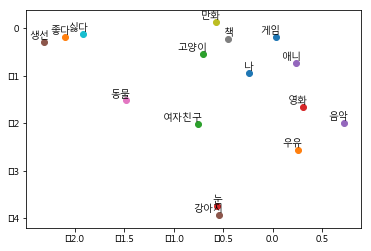

In [19]:
#########
# 임베딩된 Word2Vec 결과 확인
# 결과는 해당 단어들이 얼마나 다른 단어와 인접해 있는지를 보여줍니다.
######
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()


## Practice Code

### tf4-1_classification.py 
<hr>
``` python
# 털과 날개가 있는지 없는지에 따라, 포유류인지 조류인지 분류하는 신경망 모델을 만들어봅니다.
import tensorflow as tf
import numpy as np

# [털, 날개]
x_data = np.array(
    [[0, 0], [1, 0], [1, 1], [0, 0], [0, 0], [0, 1]])

# [기타, 포유류, 조류]
# 다음과 같은 형식을 one-hot 형식의 데이터라고 합니다.
y_data = np.array([
    [1, 0, 0],  # 기타
    [0, 1, 0],  # 포유류
    [0, 0, 1],  # 조류
    [1, 0, 0],
    [1, 0, 0],
    [0, 0, 1]
])

#########
# 신경망 모델 구성
######
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# 신경망은 2차원으로 [입력층(특성), 출력층(레이블)] -> [2, 3] 으로 정합니다.
W = tf.Variable(tf.random_uniform([2, 3], -1., 1.))

# 편향을 각각 각 레이어의 아웃풋 갯수로 설정합니다.
# 편향은 아웃풋의 갯수, 즉 최종 결과값의 분류 갯수인 3으로 설정합니다.
b = tf.Variable(tf.zeros([3]))

# 신경망에 가중치 W과 편향 b을 적용합니다
L = tf.add(tf.matmul(X, W), b)
# 가중치와 편향을 이용해 계산한 결과 값에
# 텐서플로우에서 기본적으로 제공하는 활성화 함수인 ReLU 함수를 적용합니다.
L = tf.nn.relu(L)

# 마지막으로 softmax 함수를 이용하여 출력값을 사용하기 쉽게 만듭니다
# softmax 함수는 다음처럼 결과값을 전체합이 1인 확률로 만들어주는 함수입니다.
# 예) [8.04, 2.76, -6.52] -> [0.53 0.24 0.23]
model = tf.nn.softmax(L)

# 신경망을 최적화하기 위한 비용 함수를 작성합니다.
# 각 개별 결과에 대한 합을 구한 뒤 평균을 내는 방식을 사용합니다.
# 전체 합이 아닌, 개별 결과를 구한 뒤 평균을 내는 방식을 사용하기 위해 axis 옵션을 사용합니다.
# axis 옵션이 없으면 -1.09 처럼 총합인 스칼라값으로 출력됩니다.
#        Y         model         Y * tf.log(model)   reduce_sum(axis=1)
# 예) [[1 0 0]  [[0.1 0.7 0.2]  -> [[-1.0  0    0]  -> [-1.0, -0.09]
#     [0 1 0]]  [0.2 0.8 0.0]]     [ 0   -0.09 0]]
# 즉, 이것은 예측값과 실제값 사이의 확률 분포의 차이를 비용으로 계산한 것이며,
# 이것을 Cross-Entropy 라고 합니다.
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(model), axis=1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(cost)


#########
# 신경망 모델 학습
######
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(100):
    sess.run(train_op, feed_dict={X: x_data, Y: y_data})

    if (step + 1) % 10 == 0:
        print(step + 1, sess.run(cost, feed_dict={X: x_data, Y: y_data}))


#########
# 결과 확인
# 0: 기타 1: 포유류, 2: 조류
######
# tf.argmax: 예측값과 실제값의 행렬에서 tf.argmax 를 이용해 가장 큰 값을 가져옵니다.
# 예) [[0 1 0] [1 0 0]] -> [1 0]
#    [[0.2 0.7 0.1] [0.9 0.1 0.]] -> [1 0]
prediction = tf.argmax(model, 1)
target = tf.argmax(Y, 1)
print('예측값:', sess.run(prediction, feed_dict={X: x_data}))
print('실제값:', sess.run(target, feed_dict={Y: y_data}))

is_correct = tf.equal(prediction, target)
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도: %.2f' % sess.run(accuracy * 100, feed_dict={X: x_data, Y: y_data}))


```

### tf4-2_deep_nn.py 
<hr>
``` python
# 털과 날개가 있는지 없는지에 따라, 포유류인지 조류인지 분류하는 신경망 모델을 만들어봅니다.
# 신경망의 레이어를 여러개로 구성하여 말로만 듣던 딥러닝을 구성해 봅시다!
import tensorflow as tf
import numpy as np

# [털, 날개]
x_data = np.array(
    [[0, 0], [1, 0], [1, 1], [0, 0], [0, 0], [0, 1]])

# [기타, 포유류, 조류]
y_data = np.array([
    [1, 0, 0],  # 기타
    [0, 1, 0],  # 포유류
    [0, 0, 1],  # 조류
    [1, 0, 0],
    [1, 0, 0],
    [0, 0, 1]
])

#########
# 신경망 모델 구성
######
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# 첫번째 가중치의 차원은 [특성, 히든 레이어의 뉴런갯수] -> [2, 10] 으로 정합니다.
W1 = tf.Variable(tf.random_uniform([2, 10], -1., 1.))
# 두번째 가중치의 차원을 [첫번째 히든 레이어의 뉴런 갯수, 분류 갯수] -> [10, 3] 으로 정합니다.
W2 = tf.Variable(tf.random_uniform([10, 3], -1., 1.))

# 편향을 각각 각 레이어의 아웃풋 갯수로 설정합니다.
# b1 은 히든 레이어의 뉴런 갯수로, b2 는 최종 결과값 즉, 분류 갯수인 3으로 설정합니다.
b1 = tf.Variable(tf.zeros([10]))
b2 = tf.Variable(tf.zeros([3]))

# 신경망의 히든 레이어에 가중치 W1과 편향 b1을 적용합니다
L1 = tf.add(tf.matmul(X, W1), b1)
L1 = tf.nn.relu(L1)

# 최종적인 아웃풋을 계산합니다.
# 히든레이어에 두번째 가중치 W2와 편향 b2를 적용하여 3개의 출력값을 만들어냅니다.
model = tf.add(tf.matmul(L1, W2), b2)

# 텐서플로우에서 기본적으로 제공되는 크로스 엔트로피 함수를 이용해
# 복잡한 수식을 사용하지 않고도 최적화를 위한 비용 함수를 다음처럼 간단하게 적용할 수 있습니다.
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=model))

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(cost)


#########
# 신경망 모델 학습
######
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(100):
    sess.run(train_op, feed_dict={X: x_data, Y: y_data})

    if (step + 1) % 10 == 0:
        print(step + 1, sess.run(cost, feed_dict={X: x_data, Y: y_data}))


#########
# 결과 확인
# 0: 기타 1: 포유류, 2: 조류
######
prediction = tf.argmax(model, 1)
target = tf.argmax(Y, 1)
print('예측값:', sess.run(prediction, feed_dict={X: x_data}))
print('실제값:', sess.run(target, feed_dict={Y: y_data}))

is_correct = tf.equal(prediction, target)
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도: %.2f' % sess.run(accuracy * 100, feed_dict={X: x_data, Y: y_data}))


```

### tf3_word2vec.py 
<hr>
``` python
# Word2Vec 모델을 간단하게 구현해봅니다.
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# matplot 에서 한글을 표시하기 위한 설정
font_name = matplotlib.font_manager.FontProperties(
                fname="/Library/Fonts/NanumGothic.otf"  # 한글 폰트 위치를 넣어주세요
            ).get_name()
matplotlib.rc('font', family=font_name)

# 단어 벡터를 분석해볼 임의의 문장들
sentences = ["나 고양이 좋다",
             "나 강아지 좋다",
             "나 동물 좋다",
             "강아지 고양이 동물",
             "여자친구 고양이 강아지 좋다",
             "고양이 생선 우유 좋다",
             "강아지 생선 싫다 우유 좋다",
             "강아지 고양이 눈 좋다",
             "나 여자친구 좋다",
             "여자친구 나 싫다",
             "여자친구 나 영화 책 음악 좋다",
             "나 게임 만화 애니 좋다",
             "고양이 강아지 싫다",
             "강아지 고양이 좋다"]

# 문장을 전부 합친 후 공백으로 단어들을 나누고 고유한 단어들로 리스트를 만듭니다.
word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만듭합니다.
word_dict = {w: i for i, w in enumerate(word_list)}

# 윈도우 사이즈를 1 로 하는 skip-gram 모델을 만듭니다.
# 예) 나 게임 만화 애니 좋다
#   -> ([나, 만화], 게임), ([게임, 애니], 만화), ([만화, 좋다], 애니)
#   -> (게임, 나), (게임, 만화), (만화, 게임), (만화, 애니), (애니, 만화), (애니, 좋다)
skip_grams = []

for i in range(1, len(word_sequence) - 1):
    # (context, target) : ([target index - 1, target index + 1], target)
    # 스킵그램을 만든 후, 저장은 단어의 고유 번호(index)로 저장합니다
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    # (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])


# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성하는 함수
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels


#########
# 옵션 설정
######
# 학습을 반복할 횟수
training_epoch = 300
# 학습률
learning_rate = 0.1
# 한 번에 학습할 데이터의 크기
batch_size = 20
# 단어 벡터를 구성할 임베딩 차원의 크기
# 이 예제에서는 x, y 그래프로 표현하기 쉽게 2 개의 값만 출력하도록 합니다.
embedding_size = 2
# word2vec 모델을 학습시키기 위한 nce_loss 함수에서 사용하기 위한 샘플링 크기
# batch_size 보다 작아야 합니다.
num_sampled = 15
# 총 단어 갯수
voc_size = len(word_list)


#########
# 신경망 모델 구성
######
inputs = tf.placeholder(tf.int32, shape=[batch_size])
# tf.nn.nce_loss 를 사용하려면 출력값을 이렇게 [batch_size, 1] 구성해야합니다.
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec 모델의 결과 값인 임베딩 벡터를 저장할 변수입니다.
# 총 단어 갯수와 임베딩 갯수를 크기로 하는 두 개의 차원을 갖습니다.
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# 임베딩 벡터의 차원에서 학습할 입력값에 대한 행들을 뽑아옵니다.
# 예) embeddings     inputs    selected
#    [[1, 2, 3]  -> [2, 3] -> [[2, 3, 4]
#     [2, 3, 4]                [3, 4, 5]]
#     [3, 4, 5]
#     [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# nce_loss 함수에서 사용할 변수들을 정의합니다.
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# nce_loss 함수를 직접 구현하려면 매우 복잡하지만,
# 함수를 텐서플로우가 제공하므로 그냥 tf.nn.nce_loss 함수를 사용하기만 하면 됩니다.
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


#########
# 신경망 모델 학습
######
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})

        if step % 10 == 0:
            print("loss at step ", step, ": ", loss_val)

    # matplot 으로 출력하여 시각적으로 확인해보기 위해
    # 임베딩 벡터의 결과 값을 계산하여 저장합니다.
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()


#########
# 임베딩된 Word2Vec 결과 확인
# 결과는 해당 단어들이 얼마나 다른 단어와 인접해 있는지를 보여줍니다.
######
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

```